In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sys
import os
os.getcwd()
sys.path.insert(0, '..')
from correlation_eval import theils_u

In [23]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [52]:
train_data.isna().sum(axis=0)

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
Cabin_cat              0
Survived_encoded       0
Pclass_encoded         0
Sex_encoded            0
Cabin_cat_encoded      0
Embarked_encoded       0
dtype: int64

In [53]:
test_data.isna().sum(axis=0)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Cabin_cat        0
dtype: int64

In [70]:
train_data.sort_values('Fare', ascending=False)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Survived_encoded,Pclass_encoded,Sex_encoded,Cabin_cat_encoded,Embarked_encoded
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,None,1,1,1,0,1
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,B,1,1,0,6,1
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,B,1,1,0,6,1
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,C,1,1,1,1,0
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,C,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,None,0,1,0,0,0
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S,None,0,2,0,0,0
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S,None,0,1,0,0,0
732,733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S,None,0,2,0,0,0


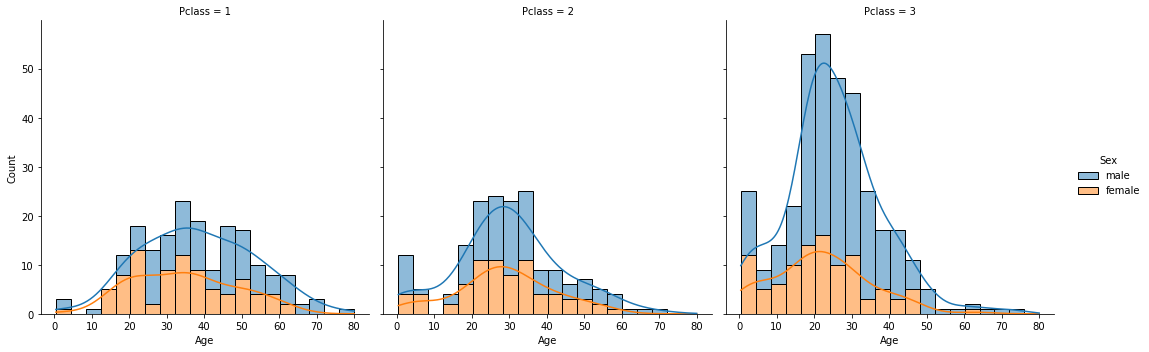

In [4]:
g=sns.displot(data=train_data, x='Age', col='Pclass', hue='Sex', multiple='stack', kde=True, kde_kws={'cut':0})

In [68]:
train_data.columns[0]

'PassengerId'

In [46]:
train_data['Cabin_cat']=train_data['Cabin'].apply(lambda x: 'None' if x is np.nan else x[0])
test_data['Cabin_cat']=test_data['Cabin'].apply(lambda x: 'None' if x is np.nan else x[0])

In [37]:
category_cols = ['Survived', 'Pclass', 'Sex', 'Cabin_cat', 'Embarked']
numerical_cols = ['Survived', 'Age', 'Fare', 'SibSp', 'Parch']

In [38]:
category_encoded_cols = [name + '_encoded' for name in category_cols]
train_data[category_encoded_cols]=train_data[category_cols].apply(lambda x: pd.factorize(x)[0])

In [63]:
corr = train_data[category_encoded_cols].corr(method=theils_u)
corr

,Survived_encoded,Pclass_encoded,Sex_encoded,Cabin_cat_encoded,Embarked_encoded
Survived_encoded,1.000000,0.087260,0.226562,0.082776,0.025031
Pclass_encoded,0.087260,1.000000,0.009525,0.363801,0.074002
Sex_encoded,0.226562,0.009525,1.000000,0.034199,0.014929
Cabin_cat_encoded,0.082776,0.363801,0.034199,1.000000,0.051315
Embarked_encoded,0.025031,0.074002,0.014929,0.051315,1.000000


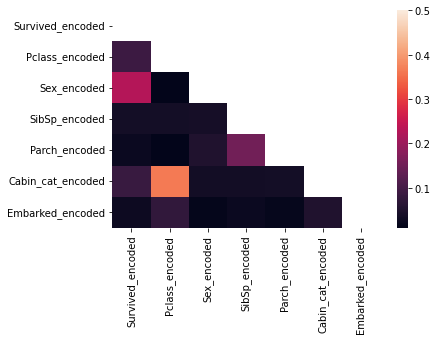

In [22]:
corr = train_data[category_encoded_cols].corr(method=theils_u)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(corr, mask=mask, vmax=0.5)

In [30]:
corr = train_data[numerical_cols].corr()
corr

,Survived,Age,Fare,SibSp,Parch
Survived,1.000000,-0.077221,0.257307,-0.035322,0.081629
Age,-0.077221,1.000000,0.096067,-0.308247,-0.189119
Fare,0.257307,0.096067,1.000000,0.159651,0.216225
SibSp,-0.035322,-0.308247,0.159651,1.000000,0.414838
Parch,0.081629,-0.189119,0.216225,0.414838,1.000000


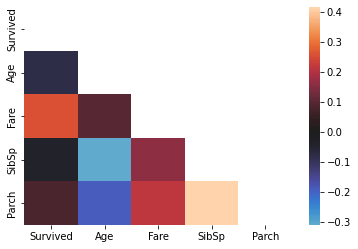

In [48]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(corr, mask=mask, center=0)

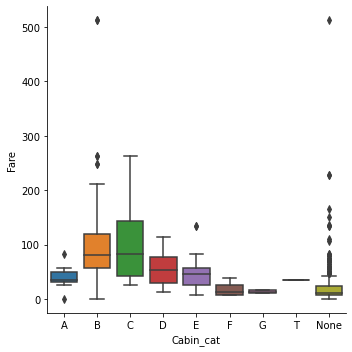

In [45]:
g = sns.catplot(data=train_data, x='Cabin_cat', y='Fare', kind='box',
                order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'None'])

In [51]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

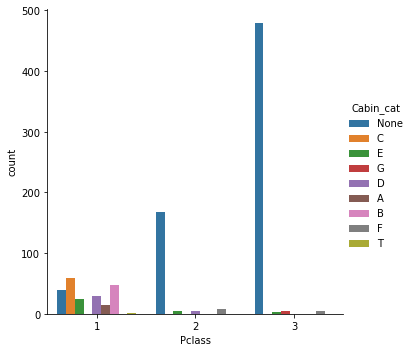

In [54]:
g = sns.catplot(data=train_data, x='Pclass', hue='Cabin_cat', kind='count')

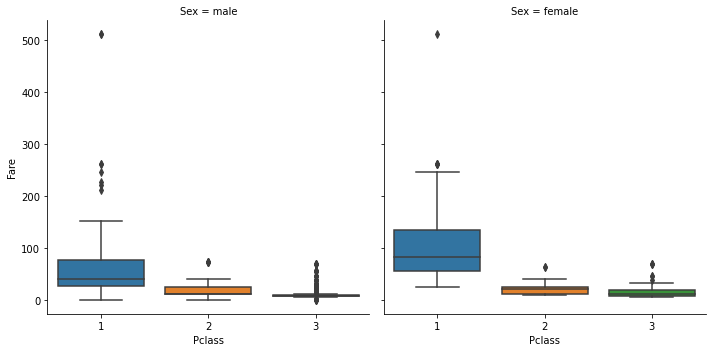

In [61]:
g = sns.catplot(data=train_data, x='Pclass', y='Fare', kind='box', col='Sex')